# Test validity step 2 : $P(s_c | ...) \propto (s_c - s_{c,WF})^t (C^{-1} + (E^t (B^t N^{-1} B)^{-1} E)^{-1}) (s_c - s_{c,WF})$

In [1]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
from jax import random, dtypes
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import numpyro.distributions as dist

import micmac as micmac

In [2]:
PRNGKey = random.PRNGKey(0)


In [3]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Shape for input frequency maps : (6, 2, 49152)
Shape for input cmb maps : (6, 2, 49152)


In [4]:
instrument

frequency  depth_p  depth_i  fwhm  f_sky    status  \
0       27.0     49.5     35.0  91.0    0.1  forecast   
1       39.0     29.7     21.0  63.0    0.1  forecast   
2       93.0      3.7      2.6  30.0    0.1  forecast   
3      145.0      4.7      3.3  17.0    0.1  forecast   
4      225.0      8.9      6.3  11.0    0.1  forecast   
5      280.0     22.6     16.0   9.0    0.1  forecast   

                                           reference    type  \
0  Journal of Cosmology and Astroparticle Physics...  ground   
1  Journal of Cosmology and Astroparticle Physics...  ground   
2  Journal of Cosmology and Astroparticle Physics...  ground   
3  Journal of Cosmology and Astroparticle Physics...  ground   
4  Journal of Cosmology and Astroparticle Physics...  ground   
5  Journal of Cosmology and Astroparticle Physics...  ground   

                                  note experiment  
0  depth_p is simply depth_i * sqrt(2)     SO_SAT  
1  depth_p is simply depth_i * sqrt(2)     SO_SAT  
2  depth_p is simply depth_i * sqrt(2)     SO_SAT  
3  depth_p is simply depth_i * sqrt(2)     SO_SAT  
4  depth_p is simply depth_i * sqrt(2)     SO_SAT  
5  depth_p is simply depth_i * sqrt(2)     SO_SAT

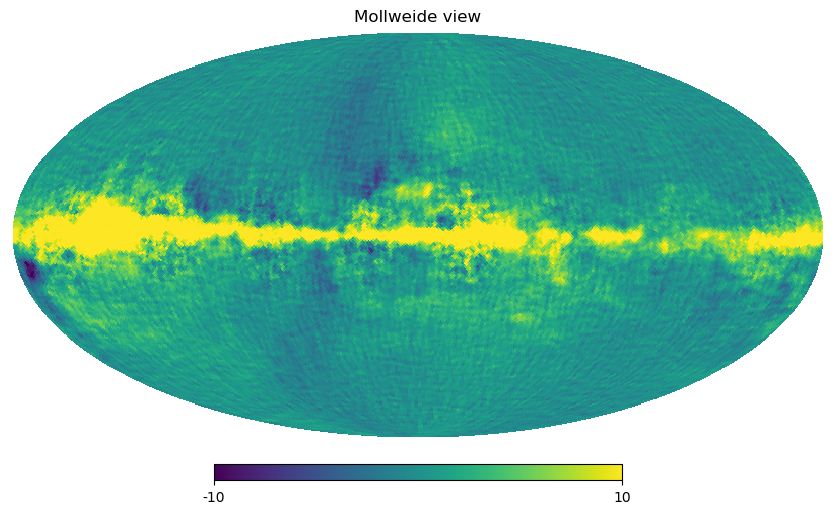

In [5]:
hp.mollview(freq_maps[2,0], min=-10, max=10) # Freq, nstokes, npix

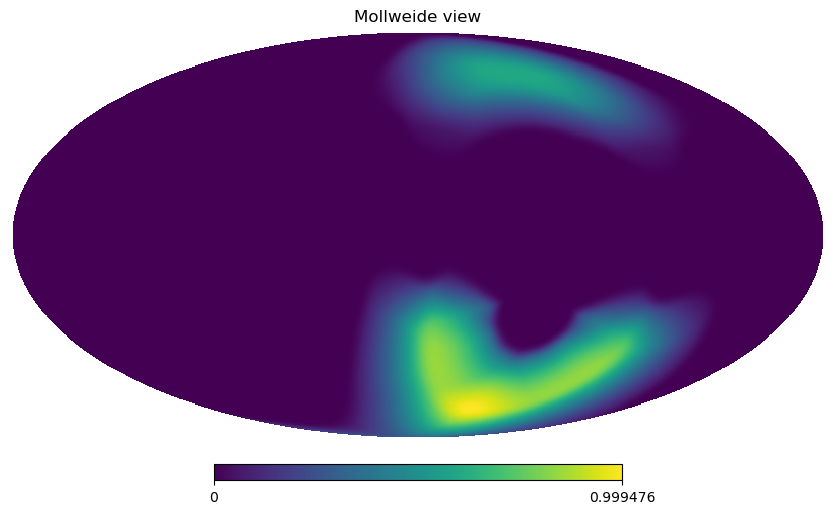

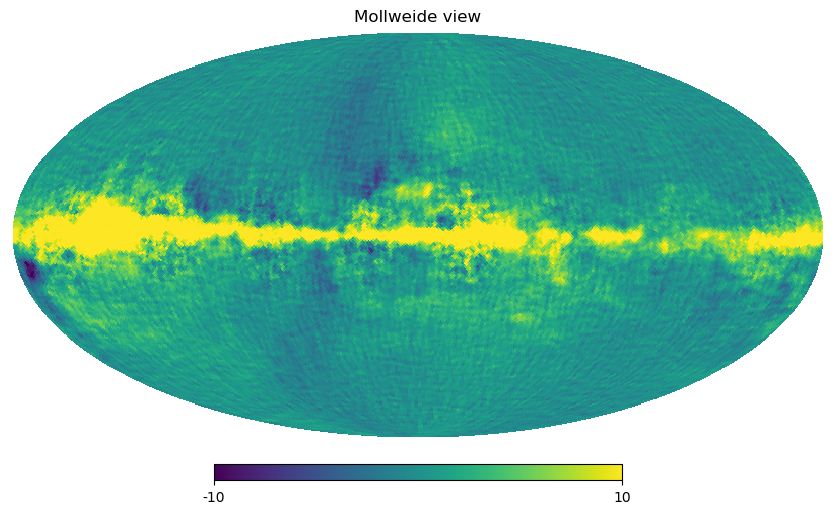

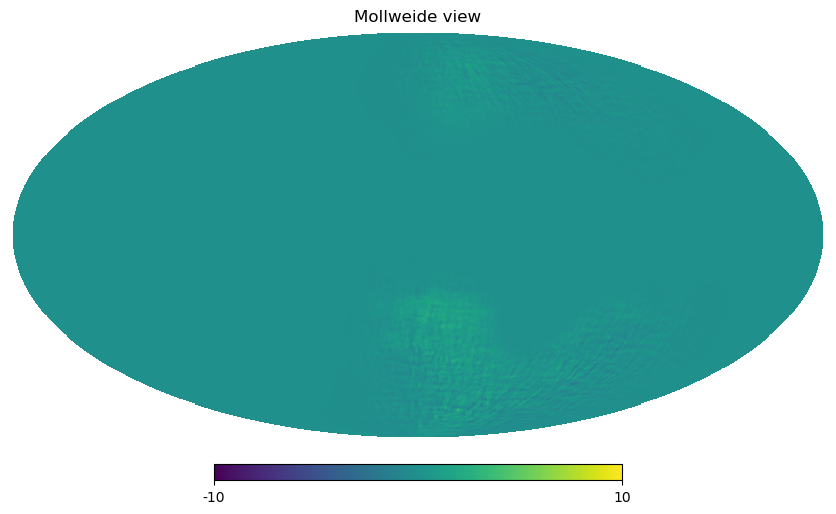

In [6]:
path_mask_test = "/Users/mag/Documents/PHD1Y/Masks/mask_SAT_apodized.fits"

mask_test = hp.read_map(path_mask_test)
hp.mollview(mask_test)
hp.mollview(freq_maps[2,0], min=-10, max=10) # Freq, nstokes, npixhp.mollview(freq_maps[0,0]) # Freq, nstokes, npix
hp.mollview(freq_maps[2,0]*hp.ud_grade(mask_test,nside_out=64), min=-10, max=10) # Freq, nstokes, npix

In [7]:
# working_directory_path = os.path.abspath('') + '/'
working_directory_path = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_chain_v5/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'toml_params/'

# path_toml_file = directory_toml_file + 'test_full_chain_v1a.toml'
# path_toml_file = directory_toml_file + 'test_classical_chain_v1a.toml'
# path_toml_file = directory_toml_file + 'test_full_chain_v1d.toml'
# path_toml_file = directory_toml_file + 'corr_full_chain_v3a.toml'
# path_toml_file = directory_toml_file + 'biased_full_chain_v1a.toml'
path_toml_file = directory_toml_file + 'biased_full_chain_v1b.toml'


In [8]:
MICMAC_sampler_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file)

In [9]:
# MICMAC_sampler_obj.limit_iter_cg = 100

In [10]:
reduction_noise = 1

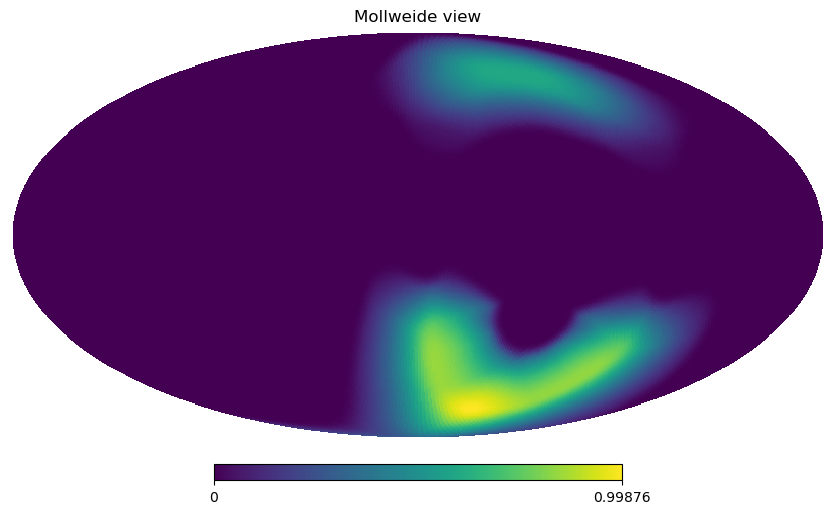

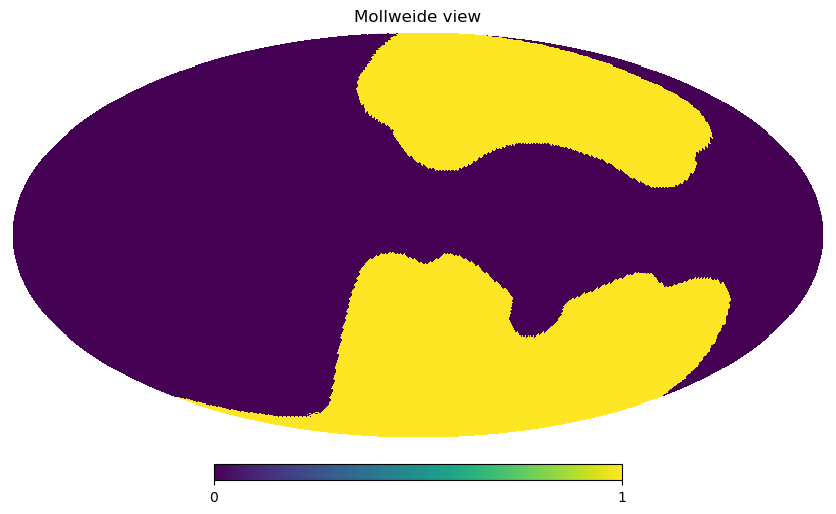

In [11]:
path_mask = "/Users/mag/Documents/PHD1Y/Masks/mask_SAT_apodized.fits"

apod_mask = hp.ud_grade(hp.read_map(path_mask_test),nside_out=MICMAC_sampler_obj.nside)
mask = np.copy(apod_mask)
mask[apod_mask>0] = 1
hp.mollview(apod_mask)
hp.mollview(mask)

In [12]:
mask = np.ones(MICMAC_sampler_obj.npix)

MICMAC_sampler_obj.mask = mask

In [13]:
# freq_inverse_noise = micmac.get_noise_covar(instrument['depth_p']/reduction_noise, MICMAC_sampler_obj.nside)
freq_inverse_noise_0 = micmac.get_noise_covar(instrument['depth_p'], MICMAC_sampler_obj.nside) #MICMAC_sampler_obj.freq_inverse_noise

freq_inverse_noise_masked = np.zeros((MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.npix))

nb_pixels_mask = int(mask.sum())
freq_inverse_noise_masked[:,:,mask!=0] = np.repeat(freq_inverse_noise_0.ravel(order='F'), nb_pixels_mask).reshape((MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.number_frequencies,nb_pixels_mask), order='C')

MICMAC_sampler_obj.freq_inverse_noise = freq_inverse_noise_masked
freq_inverse_noise = freq_inverse_noise_masked

In [14]:
instrument = get_instrument(instr_name)

instrument['depth_p'] /= reduction_noise
# get input freq maps
np.random.seed(noise_seed)
# freq_maps = get_observation(instrument, model, nside=NSIDE, noise=noise)[:, 1:, :]   # keep only Q and U
freq_maps_fgs = get_observation(instrument, fgs_model, nside=MICMAC_sampler_obj.nside, noise=noise)[:, 1:, :]   # keep only Q and U


In [15]:
indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:MICMAC_sampler_obj.nstokes]

In [16]:
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), MICMAC_sampler_obj.number_components, pos_special_freqs=MICMAC_sampler_obj.pos_special_freqs)
init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], MICMAC_sampler_obj.number_components, init_params, pos_special_freqs=MICMAC_sampler_obj.pos_special_freqs)

mixing_matrix_sampled = mixing_matrix_obj.get_B()

# BtinvNB_fullsky = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)#*mask
# BtinvN_sqrt_fullsky = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)#*mask
# BtinvN_fullsky = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)#*mask

BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)#*mask
# BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)#*mask
BtinvN_sqrt = micmac.get_BtinvN(np.sqrt(freq_inverse_noise), mixing_matrix_sampled)#*mask

BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)#*mask

nb_pix_mask = int(np.sum(mask))

# BtinvNB = np.zeros((MICMAC_sampler_obj.number_components,MICMAC_sampler_obj.number_components,MICMAC_sampler_obj.npix))
# BtinvNB[:,:,mask!=0] = np.repeat(BtinvNB_fullsky.ravel(order='C'), nb_pix_mask).reshape((MICMAC_sampler_obj.number_components, MICMAC_sampler_obj.number_components, nb_pix_mask), order='C')

# BtinvN_sqrt = np.zeros((MICMAC_sampler_obj.number_components,MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.npix))
# BtinvN_sqrt[:,:,mask!=0] = np.repeat(BtinvN_sqrt_fullsky.ravel(order='C'), nb_pix_mask).reshape((MICMAC_sampler_obj.number_components, MICMAC_sampler_obj.number_frequencies, nb_pix_mask), order='C')

# BtinvN = np.zeros((MICMAC_sampler_obj.number_components,MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.npix))
# BtinvN[:,:,mask!=0] = np.repeat(BtinvN_fullsky.ravel(order='C'), nb_pix_mask).reshape((MICMAC_sampler_obj.number_components, MICMAC_sampler_obj.number_frequencies, nb_pix_mask), order='C')


In [17]:
input_freq_maps, input_cmb_maps, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

input_freq_maps_masked = input_freq_maps*mask
# true_cmb_specra = get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true*theoretical_red_cov_r1_tensor)
# true_cmb_specra_extended = np.zeros((6,MICMAC_sampler_obj.lmax+1))
# true_cmb_specra_extended[indices_polar,MICMAC_sampler_obj.lmin:] = true_cmb_specra

# input_cmb_maps_alt = hp.synfast(true_cmb_specra_extended, nside=MICMAC_sampler_obj.nside, new=True, lmax=MICMAC_sampler_obj.lmax)[1:,...]

# input_cmb_maps = np.repeat(input_cmb_maps_alt.ravel(order='F'), MICMAC_sampler_obj.number_frequencies).reshape((MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix),order='F')

# input_cmb_maps = 

Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [18]:
s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, input_freq_maps_masked, jax_use=False)[0, :, :]

In [19]:
red_cov_matrix_sample = theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor

In [20]:
number_frequencies = MICMAC_sampler_obj.number_frequencies
number_components = MICMAC_sampler_obj.number_components
nstokes = MICMAC_sampler_obj.nstokes
lmin = MICMAC_sampler_obj.lmin
lmax = MICMAC_sampler_obj.lmax
nside = MICMAC_sampler_obj.nside
n_iter = MICMAC_sampler_obj.n_iter
npix = 12*nside**2

In [21]:
    def get_fluctuating_term_maps_v2(self, red_cov_matrix, invBtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_realization_xi=jnp.empty(0), map_random_realization_chi=jnp.empty(0), initial_guess=jnp.empty(0)):
        """ Sampling step 2 : fluctuating term

            Solve fluctuation term with formulation (C^-1 + N^-1) for the left member :
            (C^{-1} + E^t (B^t N^{-1} B)^{-1} E) \zeta = C^{-1/2} xi + (E^t (B^t N^{-1} B)^{-1} E) E^t (B^t N^{-1} B)^{-1} B^t N^{-1/2} chi

            Parameters
            ----------
            :param red_cov_matrix: term C, covariance matrices in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]
            :param invBtinvNB: matrix (B^t N^{-1} B)^{-1}, dimension [component, component, npix]
            :param BtinvN_sqrt: matrix B^T N^{-1/2}, dimension [component, frequencies, npix]

            :param jax_key_PNRG: random key for JAX PNRG
            
            :param map_white_noise_xi: set of maps 0 with mean and variance 1, which will be used to compute the fluctuation term ; dimension [nstokes, npix]
            :param map_white_noise_chi: set of maps 0 with mean and variance 1, which will be used to compute the fluctuation term ; dimension [nfreq, nstokes, npix]

            :param initial_guess: initial guess for the CG, default jnp.empty(0) (then set to 0) ; dimension [nstokes, npix]

            Returns
            -------
            :return: Fluctuation maps [nstokes, npix]
        """

        # Chex test for arguments
        chx.assert_axis_dimension(red_cov_matrix, 0, self.lmax + 1 - self.lmin)
        chx.assert_axis_dimension(invBtinvNB, 2, self.npix)
        chx.assert_axis_dimension(BtinvN_sqrt, 2, self.npix)


        jax_key_PNRG, jax_key_PNRG_xi = random.split(jax_key_PNRG) # Splitting of the random key to generate a new one
        
        # Creation of the random maps if they are not given
        if jnp.size(map_random_realization_xi) == 0:
            print("Recalculating xi !")
            # map_random_realization_xi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["nstokes"],12*param_dict["nside"]**2))
            map_random_realization_xi = jax.random.normal(jax_key_PNRG_xi, shape=(self.nstokes,self.npix))/jhp.nside2resol(self.nside)#*mask_to_use

        jax_key_PNRG, *jax_key_PNRG_chi = random.split(jax_key_PNRG,self.number_frequencies+1) # Splitting of the random key to generate a new one
        if jnp.size(map_random_realization_chi) == 0:
            print("Recalculating chi !")
            def fmap(random_key):
                random_map = jax.random.normal(random_key, shape=(self.nstokes,self.npix))#/jhp.nside2resol(nside)
                return self.get_band_limited_maps(random_map)
            map_random_realization_chi = jax.vmap(fmap)(jnp.array(jax_key_PNRG_chi))

        # Computation of the right side member of the CG
        # red_inverse_cov_matrix = jnp.linalg.pinv(red_cov_matrix)
        # red_inv_cov_sqrt = get_sqrt_reduced_matrix_from_matrix_jax(red_inverse_cov_matrix)
        red_cov_matrix_sqrt = get_sqrt_reduced_matrix_from_matrix_jax(red_cov_matrix)

        # First right member : C^{-1/2} xi
        # right_member_1 = maps_x_red_covariance_cell_JAX(map_random_realization_xi, red_inv_cov_sqrt, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter)
        right_member_1 = map_random_realization_xi

        # Second right member :
        ## Computation of N_c^{-1/2}
        N_c_inv = jnp.copy(invBtinvNB[0,0])
        N_c_inv = N_c_inv.at[...,self.mask!=0].set(1/invBtinvNB[0,0,self.mask!=0]/jhp.nside2resol(self.nside)**2)
        N_c_inv_repeat = jnp.repeat(N_c_inv.ravel(order='C'), self.nstokes).reshape((self.nstokes,self.npix), order='F').ravel()

        ## Computation of N_c^{-1/2} = (E^t (B^t N^{-1} B)^{-1} E) E^t (B^t N^{-1} B)^{-1} B^t N^{-1/2} chi
        right_member_2_part = jnp.einsum('kcp,cfp,fsp->ksp', invBtinvNB, BtinvN_sqrt, map_random_realization_chi)[0]*N_c_inv # [0] for selecting CMB component of the random variable
        right_member_2 = maps_x_red_covariance_cell_JAX(right_member_2_part, red_cov_matrix_sqrt, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter)

        right_member = (right_member_1 + right_member_2).ravel()

        # Computation of the left side member of the CG

        # Operator in harmonic domain : C^{-1}
        first_part_term_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((self.nstokes,self.npix)), red_cov_matrix_sqrt, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter)

        ## Operator in pixel domain : (E^t (B^t N^{-1} B) E)
        def second_part_term_left(x):
            return x.reshape((self.nstokes,self.npix))*N_c_inv

        third_part_term_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((self.nstokes,self.npix)), red_cov_matrix_sqrt, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter).ravel()

        transform_func = lambda x : third_part_term_left(second_part_term_left(first_part_term_left(x)))

        # Full operator to inverse : C^{-1} + 1/(E^t (B^t N^{-1} B) E)
        # func_left_term = lambda x : first_term_left(x).ravel() + second_term_left(x).ravel()
        func_left_term = lambda x : x.ravel() + transform_func(x).ravel()

        # Initial guess for the CG
        if jnp.size(initial_guess) == 0:
            initial_guess = jnp.zeros_like(map_random_realization_xi)
        else:
            # initial_guess = maps_x_red_covariance_cell_JAX(initial_guess.reshape((self.nstokes,self.npix)), jnp.linalg.pinv(red_cov_matrix_sqrt), nside=self.nside, lmin=self.lmin, n_iter=self.n_iter)
            initial_guess = maps_x_red_covariance_cell_JAX(initial_guess.reshape((self.nstokes,self.npix)), red_cov_matrix_sqrt, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter)

        # inv_first_part_term_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((self.nstokes,self.npix)), jnp.linalg.pinv(red_cov_matrix_sqrt), nside=self.nside, lmin=self.lmin, n_iter=self.n_iter).ravel()
        #         ## Second left member pixel operator : (E^t (B^t N^{-1} B)^{-1} E) x
        # def inv_second_part_term_left(x):
        #     return jnp.einsum('sp,p->sp',x.reshape((self.nstokes,self.npix)),invBtinvNB[0,0,...]*jhp.nside2resol(self.nside)**2)

        # precond_func = lambda x : x.ravel() -  inv_first_part_term_left(inv_second_part_term_left(inv_first_part_term_left(x))).ravel()/(N_c_inv).sum()

        # Actual start of the CG
        # fluctuating_map_z, number_iterations = jsp.sparse.linalg.cg(func_left_term, right_member.ravel(), x0=initial_guess.ravel(), 
        #                                                             tol=self.tolerance_CG, atol=self.tolerance_CG, maxiter=self.limit_iter_cg)

        time_start = time.time()
        fluctuating_map_z, number_iterations = jsp.sparse.linalg.cg(func_left_term, right_member.ravel(), x0=initial_guess.ravel(), 
                                                                    tol=self.tolerance_CG, maxiter=self.limit_iter_cg)#, M=precond_func)    
        print("CG Fluct finished in ", time.time()-time_start, "seconds !!")

        print("CG-Python-0 Fluct finished in ", number_iterations, "iterations !!")

        fluctuating_map = maps_x_red_covariance_cell_JAX(fluctuating_map_z.reshape((self.nstokes,self.npix)), red_cov_matrix_sqrt, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter)

        return fluctuating_map.reshape((self.nstokes, self.npix))


    def solve_generalized_wiener_filter_term_v2(self, s_cML, red_cov_matrix, invBtinvNB, initial_guess=jnp.empty(0)):
        """ 
            Solve Wiener filter term with CG : (C^{-1} + N_c^-1) s_c,WF = N_c^{-1} s_c,ML

            Parameters
            ----------
            :param s_cML: Maximum Likelihood solution of component separation from input frequency maps ; dimensions [nstokes, npix]
            :param red_cov_matrix: covariance matrices in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]
            :param invBtinvNB: matrix (B^t N^{-1} B)^{-1}, dimension [component, component, npix]
            
            :param initial_guess: initial guess for the CG, default jnp.empty(0) (then set to 0) ; dimension [nstokes, npix]

            Returns
            -------
            :return: Wiener filter maps [nstokes, npix]
        """

        # Chex test for arguments
        chx.assert_axis_dimension(red_cov_matrix, 0, self.lmax + 1 - self.lmin)
        if self.nstokes != 1:
            chx.assert_axis_dimension(s_cML, 0, self.nstokes)
            chx.assert_axis_dimension(s_cML, 1, self.npix)
        chx.assert_axis_dimension(invBtinvNB, 2, self.npix)

        red_cov_matrix_sqrt = get_sqrt_reduced_matrix_from_matrix_jax(red_cov_matrix)

        # Computation of the right side member of the CG : N_c^{-1} s_c,ML
        ## First, comutation of N_c^{-1} (putting it to 0 outside the mask)
        N_c_inv = jnp.copy(invBtinvNB[0,0])
        N_c_inv = N_c_inv.at[...,self.mask!=0].set(1/invBtinvNB[0,0,self.mask!=0]/jhp.nside2resol(self.nside)**2)
        N_c_inv_repeat = jnp.repeat(N_c_inv.ravel(order='C'), self.nstokes).reshape((self.nstokes,self.npix), order='F').ravel()

        ## Then, computation of N_c^{-1} s_c,ML
        # right_member = (s_cML*N_c_inv).ravel()
        right_member = maps_x_red_covariance_cell_JAX(s_cML*N_c_inv, red_cov_matrix_sqrt, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter).ravel()
        

        # Preparation of the harmonic operator C^{-1} for the LHS of the CG
        first_part_term_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((self.nstokes,self.npix)), red_cov_matrix_sqrt, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter).ravel()
        
        ## Second left member pixel operator : (E^t (B^t N^{-1} B)^{-1} E) x
        def second_part_term_left(x):
            # return x*N_c_inv_repeat
            return x.reshape((self.nstokes,self.npix))*N_c_inv

        transform_func = lambda x : first_part_term_left(second_part_term_left(first_part_term_left(x)))

        # Full operator to inverse : C^{-1} + (E^t (B^t N^{-1} B) E)
        # func_left_term = lambda x : first_term_left(x).ravel() + second_term_left(x).ravel()
        func_left_term = lambda x : x.ravel() + transform_func(x).ravel()

        # Initial guess for the CG
        if jnp.size(initial_guess) == 0:
            initial_guess = jnp.zeros_like(s_cML)
        else:
            initial_guess = maps_x_red_covariance_cell_JAX(initial_guess.reshape((self.nstokes,self.npix)), red_cov_matrix_sqrt, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter)

        # inv_first_part_term_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((self.nstokes,self.npix)), jnp.linalg.pinv(red_cov_matrix_sqrt), nside=self.nside, lmin=self.lmin, n_iter=self.n_iter).ravel()
        #         ## Second left member pixel operator : (E^t (B^t N^{-1} B)^{-1} E) x
        # def inv_second_part_term_left(x):
        #     return jnp.einsum('sp,p->sp',x.reshape((self.nstokes,self.npix)),invBtinvNB[0,0,...]*jhp.nside2resol(self.nside)**2)

        # precond_func = lambda x : x.ravel() -  inv_first_part_term_left(inv_second_part_term_left(inv_first_part_term_left(x))).ravel()/(N_c_inv).sum()


        # Actual start of the CG
        # wiener_filter_term_z, number_iterations = jsp.sparse.linalg.cg(func_left_term, right_member.ravel(), x0=initial_guess.ravel(), tol=self.tolerance_CG, atol=self.tolerance_CG, maxiter=self.limit_iter_cg)
        wiener_filter_term_z, number_iterations = jsp.sparse.linalg.cg(func_left_term, right_member.ravel(), x0=initial_guess.ravel(), 
                                                                        tol=self.tolerance_CG, maxiter=self.limit_iter_cg)#, M=precond_func)
        print("CG-Python-0 WF finished in ", number_iterations, "iterations !!")

        wiener_filter_term = maps_x_red_covariance_cell_JAX(wiener_filter_term_z.reshape((self.nstokes,self.npix)), red_cov_matrix_sqrt, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter)

        return wiener_filter_term.reshape((self.nstokes, self.npix))

    def get_fluctuating_term_maps_v3(self, red_cov_matrix, invBtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_realization_xi=jnp.empty(0), map_random_realization_chi=jnp.empty(0), initial_guess=jnp.empty(0)):
        """ Sampling step 2 : fluctuating term

            Solve fluctuation term with formulation (C^-1 + N^-1) for the left member :
            (C^{-1} + E^t (B^t N^{-1} B)^{-1} E) \zeta = C^{-1/2} xi + (E^t (B^t N^{-1} B)^{-1} E) E^t (B^t N^{-1} B)^{-1} B^t N^{-1/2} chi

            Parameters
            ----------
            :param red_cov_matrix: term C, covariance matrices in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]
            :param invBtinvNB: matrix (B^t N^{-1} B)^{-1}, dimension [component, component, npix]
            :param BtinvN_sqrt: matrix B^T N^{-1/2}, dimension [component, frequencies, npix]

            :param jax_key_PNRG: random key for JAX PNRG
            
            :param map_white_noise_xi: set of maps 0 with mean and variance 1, which will be used to compute the fluctuation term ; dimension [nstokes, npix]
            :param map_white_noise_chi: set of maps 0 with mean and variance 1, which will be used to compute the fluctuation term ; dimension [nfreq, nstokes, npix]

            :param initial_guess: initial guess for the CG, default jnp.empty(0) (then set to 0) ; dimension [nstokes, npix]

            Returns
            -------
            :return: Fluctuation maps [nstokes, npix]
        """

        # Chex test for arguments
        chx.assert_axis_dimension(red_cov_matrix, 0, self.lmax + 1 - self.lmin)
        chx.assert_axis_dimension(invBtinvNB, 2, self.npix)
        chx.assert_axis_dimension(BtinvN_sqrt, 2, self.npix)


        jax_key_PNRG, jax_key_PNRG_xi = random.split(jax_key_PNRG) # Splitting of the random key to generate a new one

        # Creation of the random maps if they are not given
        if jnp.size(map_random_realization_xi) == 0:
            print("Recalculating xi !")
            # map_random_realization_xi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["nstokes"],12*param_dict["nside"]**2))
            map_random_realization_xi = jax.random.normal(jax_key_PNRG_xi, shape=(self.nstokes,self.npix))/jhp.nside2resol(self.nside)#*mask_to_use

        jax_key_PNRG, *jax_key_PNRG_chi = random.split(jax_key_PNRG,self.number_frequencies+1) # Splitting of the random key to generate a new one
        if jnp.size(map_random_realization_chi) == 0:
            print("Recalculating chi !")
            def fmap(random_key):
                random_map = jax.random.normal(random_key, shape=(self.nstokes,self.npix))#/jhp.nside2resol(nside)
                return self.get_band_limited_maps(random_map)
            map_random_realization_chi = jax.vmap(fmap)(jnp.array(jax_key_PNRG_chi))

        # Computation of the right side member of the CG
        # red_inverse_cov_matrix = jnp.linalg.pinv(red_cov_matrix)
        # red_inv_cov_sqrt = get_sqrt_reduced_matrix_from_matrix_jax(jnp.linalg.pinv(red_cov_matrix))
        red_cov_matrix_sqrt = get_sqrt_reduced_matrix_from_matrix_jax(red_cov_matrix)

        # First right member : C^{-1/2} xi
        right_member_1 = maps_x_red_covariance_cell_JAX(map_random_realization_xi, jnp.linalg.pinv(red_cov_matrix_sqrt), nside=self.nside, lmin=self.lmin, n_iter=self.n_iter)
        # right_member_1 = map_random_realization_xi

        # Second right member :
        ## Computation of N_c^{-1/2}
        N_c_inv = jnp.copy(invBtinvNB[0,0])
        N_c_inv = N_c_inv.at[...,self.mask!=0].set(1/invBtinvNB[0,0,self.mask!=0]/jhp.nside2resol(self.nside)**2)
        N_c_inv_repeat = jnp.repeat(N_c_inv.ravel(order='C'), self.nstokes).reshape((self.nstokes,self.npix), order='F').ravel()

        ## Computation of N_c^{-1/2} = (E^t (B^t N^{-1} B)^{-1} E) E^t (B^t N^{-1} B)^{-1} B^t N^{-1/2} chi
        # right_member_2_part = jnp.einsum('kcp,cfp,fsp->ksp', invBtinvNB, BtinvN_sqrt, map_random_realization_chi)[0]*N_c_inv # [0] for selecting CMB component of the random variable
        right_member_2 = jnp.einsum('kcp,cfp,fsp->ksp', invBtinvNB, BtinvN_sqrt, map_random_realization_chi)[0]*N_c_inv # [0] for selecting CMB component of the random variable
        # right_member_2 = maps_x_red_covariance_cell_JAX(right_member_2_part, red_cov_matrix_sqrt, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter)

        right_member = (right_member_1 + right_member_2).ravel()

        # Computation of the left side member of the CG

        # Operator in harmonic domain : C^{-1}
        first_part_term_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((self.nstokes,self.npix)), red_cov_matrix_sqrt, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter)

        ## Operator in pixel domain : (E^t (B^t N^{-1} B) E)
        def second_part_term_left(x):
            return x.reshape((self.nstokes,self.npix))*N_c_inv

        third_part_term_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((self.nstokes,self.npix)), jnp.linalg.pinv(red_cov_matrix_sqrt), nside=self.nside, lmin=self.lmin, n_iter=self.n_iter).ravel()

        # transform_func = lambda x : third_part_term_left(second_part_term_left(x))
        transform_func = lambda x : second_part_term_left(first_part_term_left(x))

        # Full operator to inverse : C^{-1} + 1/(E^t (B^t N^{-1} B) E)
        # func_left_term = lambda x : first_term_left(x).ravel() + second_term_left(x).ravel()
        func_left_term = lambda x : third_part_term_left(x).ravel() + transform_func(x).ravel()

        # Initial guess for the CG
        if jnp.size(initial_guess) == 0:
            initial_guess = jnp.zeros_like(map_random_realization_xi)
        # else:
        #     initial_guess = maps_x_red_covariance_cell_JAX(initial_guess.reshape((self.nstokes,self.npix)), jnp.linalg.pinv(red_cov_matrix_sqrt), nside=self.nside, lmin=self.lmin, n_iter=self.n_iter)

        # Actual start of the CG
        # fluctuating_map_z, number_iterations = jsp.sparse.linalg.cg(func_left_term, right_member.ravel(), x0=initial_guess.ravel(), 
        #                                                             tol=self.tolerance_CG, atol=self.tolerance_CG, maxiter=self.limit_iter_cg)

        fluctuating_map, number_iterations = jsp.sparse.linalg.cg(func_left_term, right_member.ravel(), x0=initial_guess.ravel(), 
                                                                    tol=self.tolerance_CG, maxiter=self.limit_iter_cg)    
        print("CG-Python-0 Fluct finished in ", number_iterations, "iterations !!")

        # fluctuating_map = maps_x_red_covariance_cell_JAX(fluctuating_map_z.reshape((self.nstokes,self.npix)), red_cov_matrix_sqrt, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter)

        return fluctuating_map.reshape((self.nstokes, self.npix))


In [22]:
MICMAC_sampler_obj.tolerance_CG = 1e-6

In [23]:
%%time
PRNGKey = random.PRNGKey(0)
map_random_realization_xi = jnp.empty(0)
map_random_realization_chi = jnp.empty(0)
# fluctuation_maps_v2 = get_fluctuating_term_maps_v2(red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey+2, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=jnp.empty(0))
fluctuation_maps_v2 = MICMAC_sampler_obj.get_fluctuating_term_maps_v2(red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey+2, 
                                                                        map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, 
                                                                        initial_guess=jnp.empty(0))
# fluctuation_maps_v2 = get_fluctuating_term_maps_v2(MICMAC_sampler_obj, red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey+2, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=jnp.empty(0))


Recalculating xi !
Recalculating chi !
CG-Python-0 Fluct finished in  None iterations !!
CPU times: user 56.4 s, sys: 7.6 s, total: 1min 4s
Wall time: 21.8 s


In [24]:
%%time
PRNGKey = random.PRNGKey(0)
map_random_realization_xi = jnp.empty(0)
map_random_realization_chi = jnp.empty(0)
# fluctuation_maps_v2 = get_fluctuating_term_maps_v2(red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey+2, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=jnp.empty(0))
fluctuation_maps_v2 = get_fluctuating_term_maps_v2(MICMAC_sampler_obj, red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey+2, 
                                                                        map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, 
                                                                        initial_guess=fluctuation_maps_v2)
# fluctuation_maps_v2 = get_fluctuating_term_maps_v2(MICMAC_sampler_obj, red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey+2, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=jnp.empty(0))


Recalculating xi !
Recalculating chi !
CG Fluct finished in  18.25300121307373 seconds !!
CG-Python-0 Fluct finished in  None iterations !!
CPU times: user 54.7 s, sys: 7.87 s, total: 1min 2s
Wall time: 19.4 s


In [25]:
%%time
# wiener_filter_term_v2 = solve_generalized_wiener_filter_term_v2(s_cML, red_cov_matrix_sample, BtinvNB, initial_guess=jnp.empty(0))
wiener_filter_term_v2 = MICMAC_sampler_obj.solve_generalized_wiener_filter_term_v2(s_cML, red_cov_matrix_sample, BtinvNB, initial_guess=jnp.empty(0))


CG-Python-0 WF finished in  None iterations !!
CPU times: user 46.1 s, sys: 6.45 s, total: 52.6 s
Wall time: 16.4 s


In [27]:
%%time
# wiener_filter_term_v2 = solve_generalized_wiener_filter_term_v2(s_cML, red_cov_matrix_sample, BtinvNB, initial_guess=jnp.empty(0))
wiener_filter_term_v2 = MICMAC_sampler_obj.solve_generalized_wiener_filter_term_v2(s_cML, red_cov_matrix_sample, BtinvNB, initial_guess=wiener_filter_term_v2)


CG-Python-0 WF finished in  None iterations !!
CPU times: user 42.7 s, sys: 5.81 s, total: 48.5 s
Wall time: 15.1 s


In [28]:
# %%time
# # wiener_filter_term_v2 = solve_generalized_wiener_filter_term_v2(s_cML, red_cov_matrix_sample, BtinvNB, initial_guess=jnp.empty(0))
# wiener_filter_term_v2 = solve_generalized_wiener_filter_term_v2(MICMAC_sampler_obj, s_cML, red_cov_matrix_sample, BtinvNB, initial_guess=jnp.empty(0))


In [29]:
%%time
PRNGKey = random.PRNGKey(0)
map_random_realization_xi = jnp.empty(0)
map_random_realization_chi = jnp.empty(0)
# fluctuation_maps_v2 = get_fluctuating_term_maps_v2(red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey+2, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=jnp.empty(0))
# fluctuation_maps_v3 = MICMAC_sampler_obj.get_fluctuating_term_maps_v3(red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey+2, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=jnp.empty(0))
fluctuation_maps_v3 = get_fluctuating_term_maps_v3(MICMAC_sampler_obj, red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey+2, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=jnp.empty(0))


Recalculating xi !
Recalculating chi !
CG-Python-0 Fluct finished in  None iterations !!
CPU times: user 12.8 s, sys: 1.86 s, total: 14.7 s
Wall time: 4.81 s


In [30]:
%%time
# wiener_filter_term_v2 = solve_generalized_wiener_filter_term_v2(s_cML, red_cov_matrix_sample, BtinvNB, initial_guess=jnp.empty(0))
# wiener_filter_term_v3 = MICMAC_sampler_obj.solve_generalized_wiener_filter_term_v3(s_cML, red_cov_matrix_sample, BtinvNB, initial_guess=jnp.empty(0))


CPU times: user 13 µs, sys: 1e+03 ns, total: 14 µs
Wall time: 4.05 µs


In [31]:
%%time
PRNGKey = random.PRNGKey(0)
map_random_realization_xi = jnp.empty(0)
map_random_realization_chi = jnp.empty(0)
fluctuation_maps = MICMAC_sampler_obj.get_fluctuating_term_maps(red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey+2, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=jnp.empty(0))
# fluctuation_maps = get_fluctuating_term_maps_test(red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey+2, mask_to_use=mask, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=jnp.empty(0))
print("Finished fluct !")


Recalculating xi !
Recalculating chi !
CG-Python-0 Fluct finished in  None iterations !!
Finished fluct !
CPU times: user 3.75 s, sys: 703 ms, total: 4.46 s
Wall time: 1.59 s


In [32]:
jitted_get_fluctuating_term_maps = jax.jit(MICMAC_sampler_obj.get_fluctuating_term_maps)

In [33]:
%%time
fluctuation_maps = jitted_get_fluctuating_term_maps(red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey+2, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=jnp.empty(0))

Recalculating xi !
Recalculating chi !
CG-Python-0 Fluct finished in  None iterations !!
CPU times: user 4.43 s, sys: 637 ms, total: 5.06 s
Wall time: 2.33 s


In [34]:
%%time
fluctuation_maps = jitted_get_fluctuating_term_maps(red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey+2, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=jnp.empty(0))


CPU times: user 1.93 s, sys: 249 ms, total: 2.18 s
Wall time: 637 ms


In [35]:
%%time
fluctuation_maps = jitted_get_fluctuating_term_maps(red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey+2, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=jnp.empty(0))


CPU times: user 2.04 s, sys: 284 ms, total: 2.32 s
Wall time: 641 ms


In [36]:
%%time
wiener_filter_term = MICMAC_sampler_obj.solve_generalized_wiener_filter_term(s_cML, red_cov_matrix_sample, BtinvNB, initial_guess=jnp.empty(0))


CG-Python-0 WF finished in  None iterations !!
CPU times: user 1.9 s, sys: 344 ms, total: 2.24 s
Wall time: 744 ms


In [37]:
jitted_solve_generalized_wiener_filter_term = jax.jit(MICMAC_sampler_obj.solve_generalized_wiener_filter_term)

In [38]:
%%time
wiener_filter_term = jitted_solve_generalized_wiener_filter_term(s_cML, red_cov_matrix_sample, BtinvNB, initial_guess=jnp.empty(0))


CG-Python-0 WF finished in  None iterations !!
CPU times: user 1.65 s, sys: 219 ms, total: 1.87 s
Wall time: 752 ms


In [39]:
%%time
wiener_filter_term = jitted_solve_generalized_wiener_filter_term(s_cML, red_cov_matrix_sample, BtinvNB, initial_guess=jnp.empty(0))


CPU times: user 1.04 s, sys: 136 ms, total: 1.17 s
Wall time: 361 ms


In [40]:
# %%time
# wiener_filter_term = jitted_solve_generalized_wiener_filter_term(s_cML, red_cov_matrix_sample, BtinvNB, initial_guess=jnp.empty(0))


In [41]:
# wiener_filter_term = wiener_filter_term*mask

In [42]:
s_c_sample = wiener_filter_term + fluctuation_maps

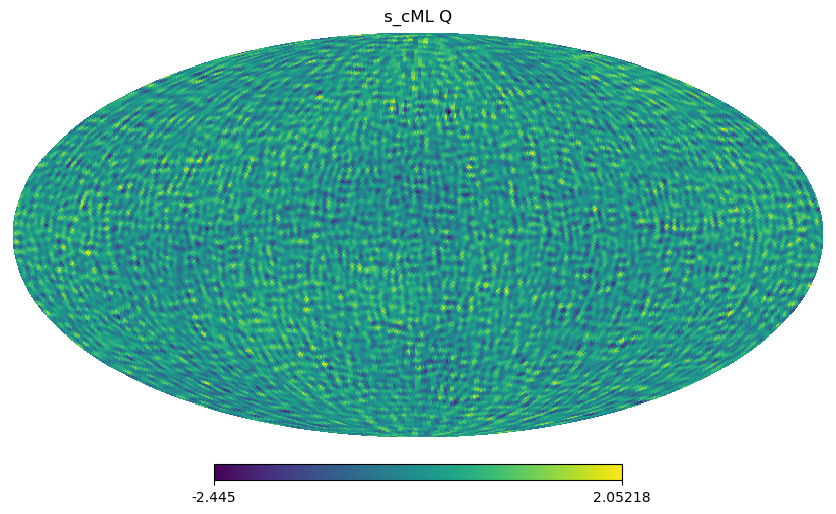

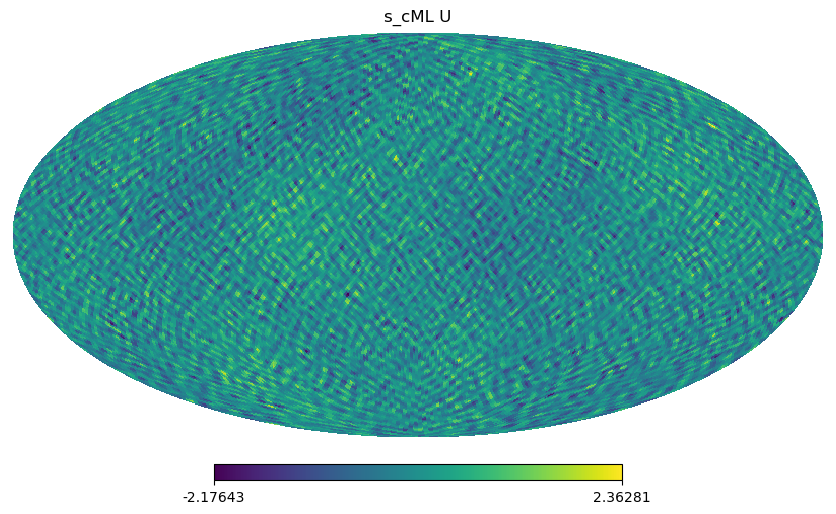

In [43]:
hp.mollview(s_cML[0], title='s_cML Q')
hp.mollview(s_cML[1], title='s_cML U')

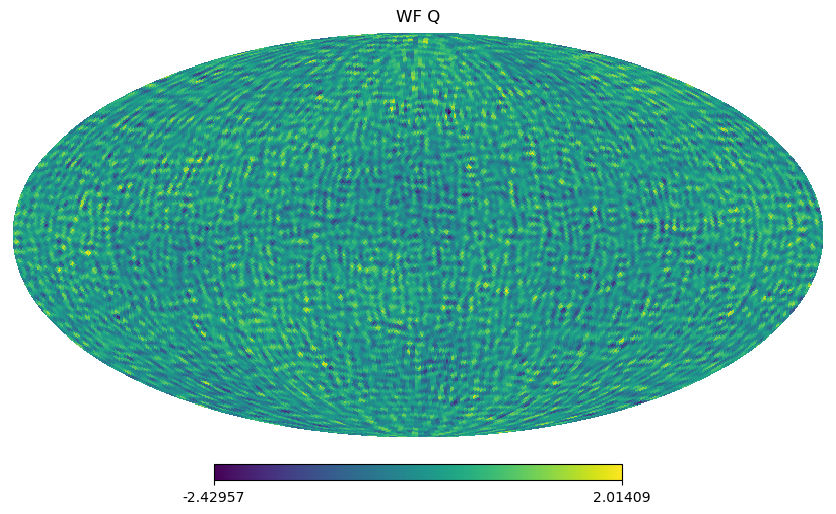

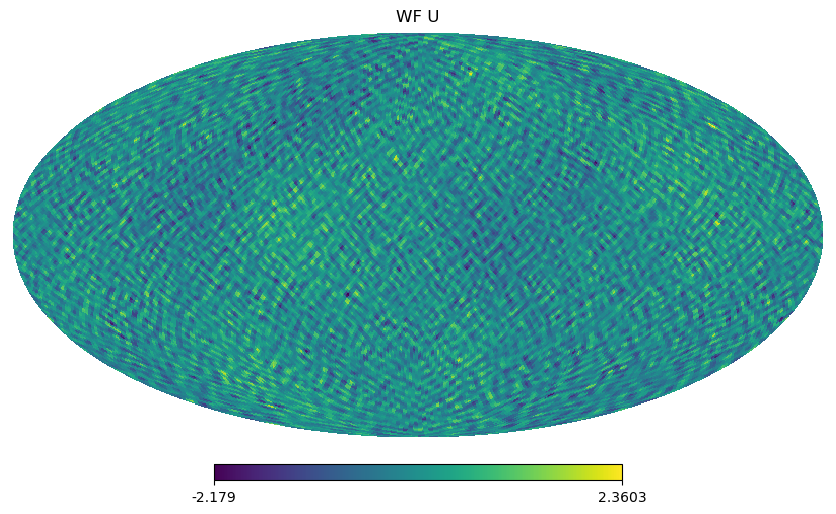

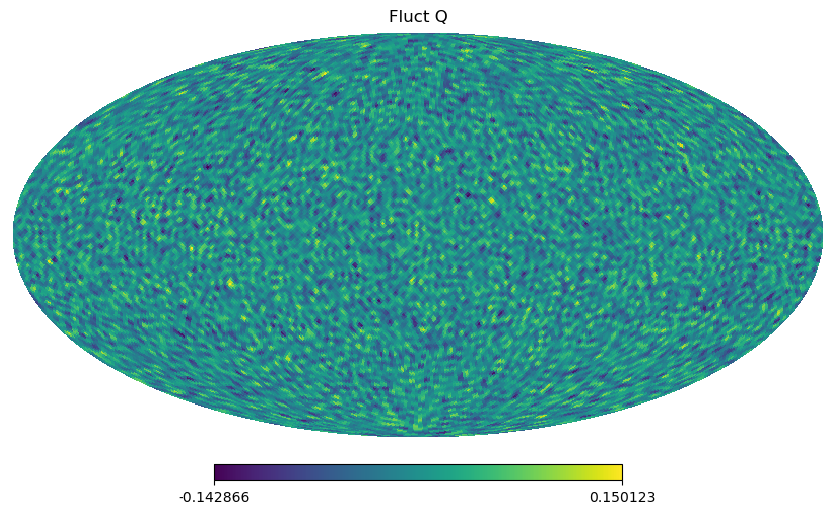

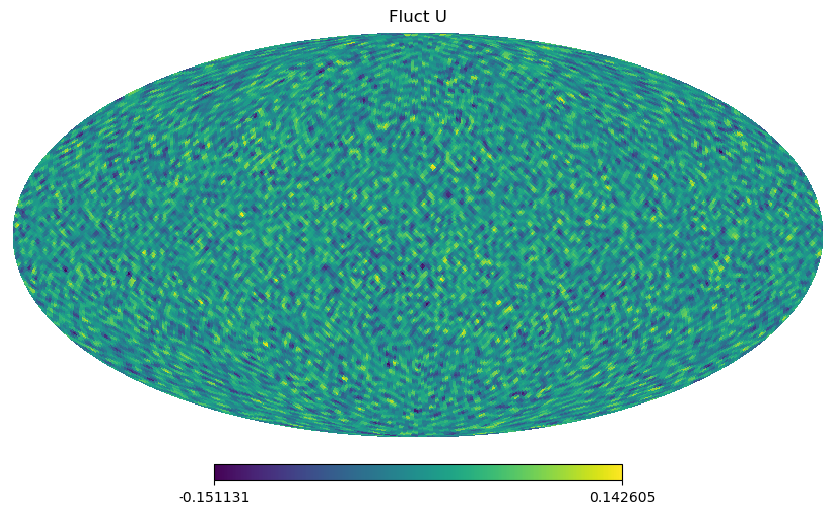

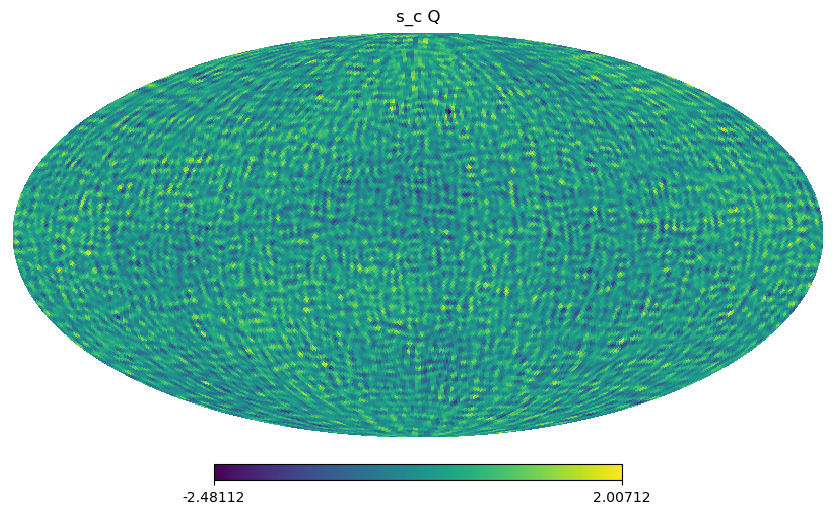

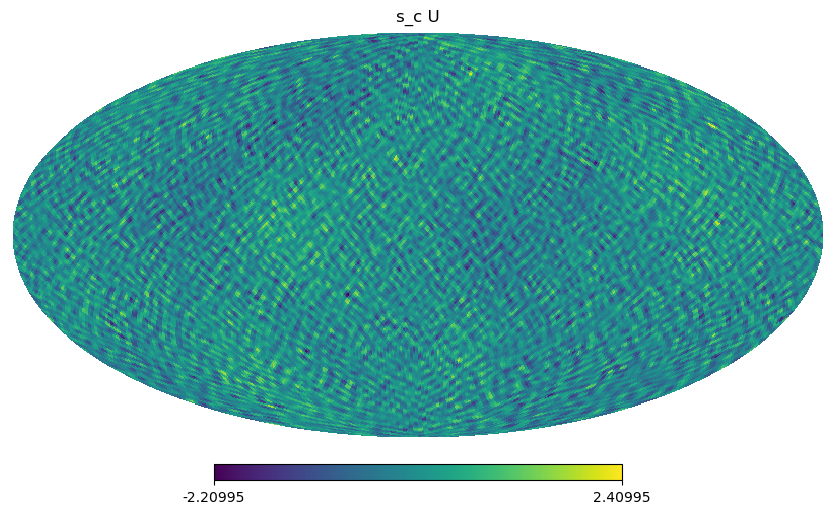

In [44]:
hp.mollview(wiener_filter_term[0], title='WF Q')
hp.mollview(wiener_filter_term[1], title='WF U')

hp.mollview(fluctuation_maps[0], title='Fluct Q')
hp.mollview(fluctuation_maps[1], title='Fluct U')

hp.mollview(s_c_sample[0], title='s_c Q')
hp.mollview(s_c_sample[1], title='s_c U')

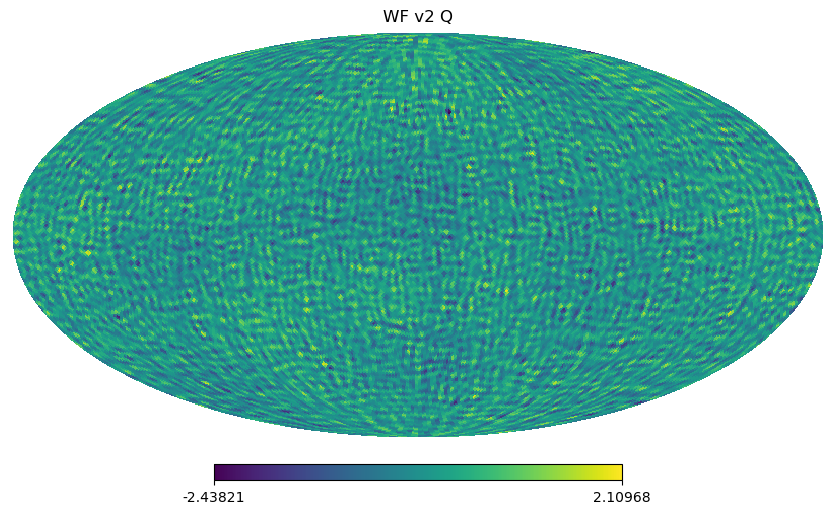

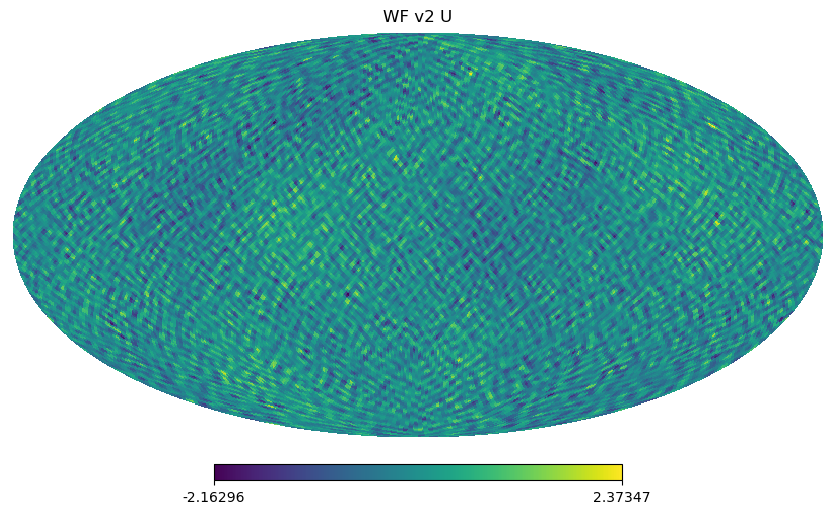

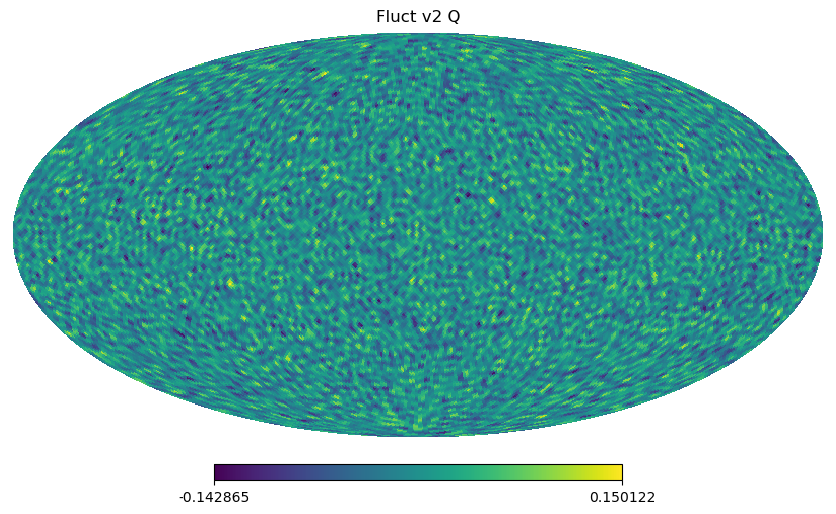

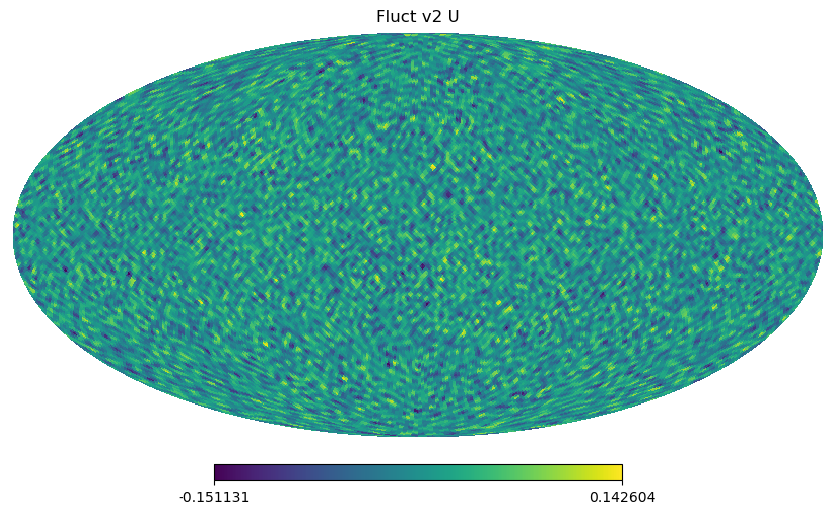

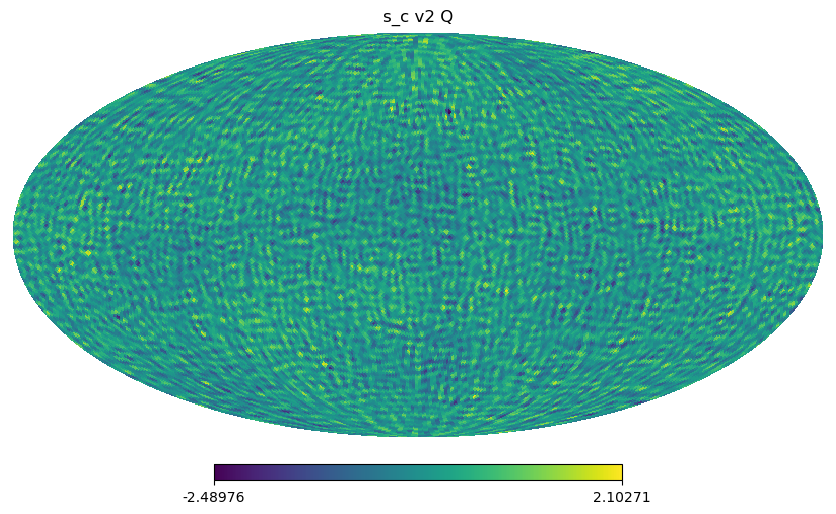

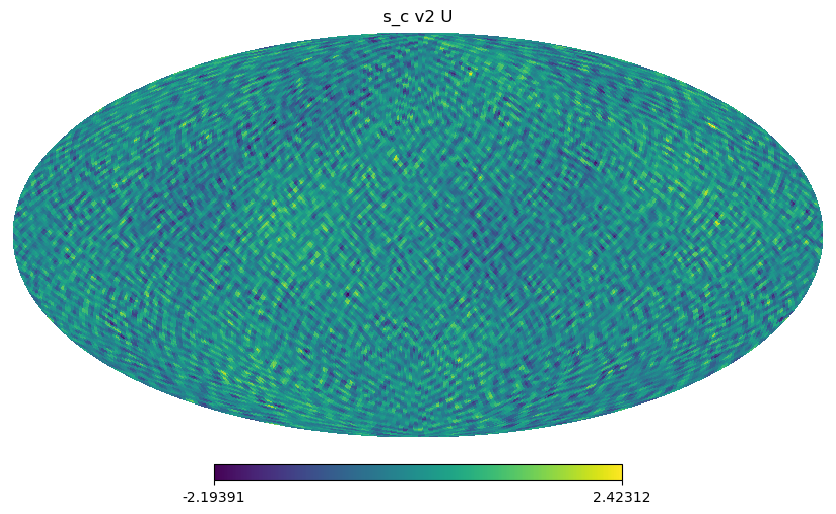

In [45]:
hp.mollview(wiener_filter_term_v2[0], title='WF v2 Q')
hp.mollview(wiener_filter_term_v2[1], title='WF v2 U')

hp.mollview(fluctuation_maps_v2[0], title='Fluct v2 Q')
hp.mollview(fluctuation_maps_v2[1], title='Fluct v2 U')

hp.mollview((wiener_filter_term_v2+fluctuation_maps_v2)[0], title='s_c v2 Q')
hp.mollview((wiener_filter_term_v2+fluctuation_maps_v2)[1], title='s_c v2 U')

In [46]:
hp.mollview(wiener_filter_term_v3[0], title='WF v3 Q')
hp.mollview(wiener_filter_term_v3[1], title='WF v3 U')

hp.mollview(fluctuation_maps_v3[0], title='Fluct v3 Q')
hp.mollview(fluctuation_maps_v3[1], title='Fluct v3 U')

hp.mollview((wiener_filter_term_v3+fluctuation_maps_v3)[0], title='s_c v3 Q')
hp.mollview((wiener_filter_term_v3+fluctuation_maps_v3)[1], title='s_c v3 U')

NameError: name 'wiener_filter_term_v3' is not defined

In [ ]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

In [ ]:
_cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled, lmax)[0,0,lmin:]
red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

In [ ]:
fsky = mask.sum()/mask.size
fsky = 1#mask.sum()/mask.size

/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


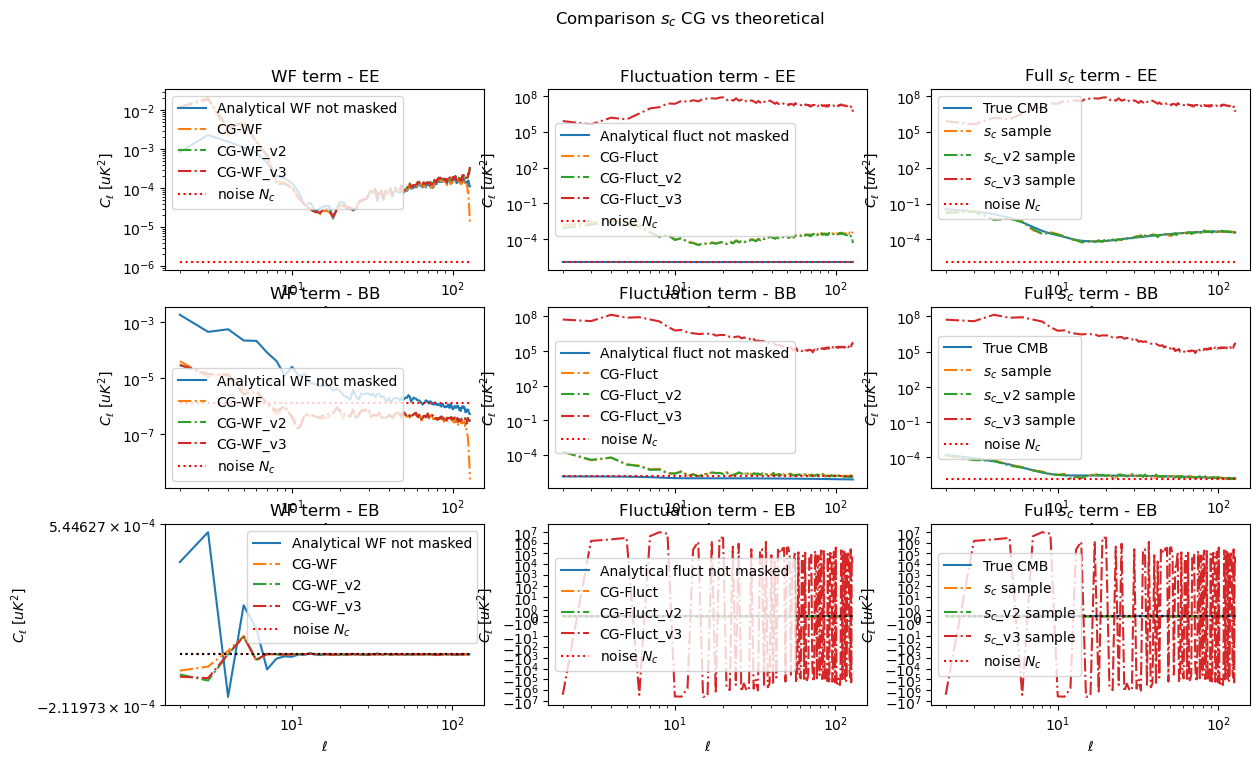

In [ ]:
list_correl = ['EE', 'BB', 'EB']

c_ell_true_CMB = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor)

covariance_noise = np.zeros_like(c_ell_true_CMB)

# analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix_sample) + np.eye(nstokes)/BtinvNB[0,0])
# # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
# analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0], analytical_WF_harm, lmin=lmin, n_iter=n_iter)
analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix_sample) + np.linalg.pinv(red_cl_noise_harm))
# analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
N_c_inv = jnp.copy(BtinvNB[0,0])
N_c_inv = N_c_inv.at[...,mask!=0].set(1/BtinvNB[0,0,mask!=0]/jhp.nside2resol(nside)**2)

# analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0]/hp.nside2resol(MICMAC_sampler_obj.nside)**2,
#                                                                         analytical_WF_harm, lmin=lmin, n_iter=n_iter)

s_cML_unmasked = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, input_freq_maps, jax_use=False)[0, :, :]
analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML_unmasked/BtinvNB[0,0,0]/hp.nside2resol(MICMAC_sampler_obj.nside)**2,
                                                                        analytical_WF_harm, lmin=lmin, n_iter=n_iter)

analytical_WF_map_ext = np.vstack([np.zeros_like(analytical_WF_map[0]),analytical_WF_map])
analytical_WF_cells = hp.anafast(analytical_WF_map_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]
analytical_fluct_c_ell = micmac.get_c_ells_from_red_covariance_matrix(analytical_WF_harm.copy())#[indices_polar,lmin:]

s_c_WF_maps_extended = np.vstack([np.zeros_like(wiener_filter_term[0,...]), wiener_filter_term])
c_ells_s_c_WF = hp.anafast(s_c_WF_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_fluct_maps_extended = np.vstack([np.zeros_like(fluctuation_maps[0,...]), fluctuation_maps])
c_ells_s_c_fluct = hp.anafast(s_c_fluct_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_recovered_ext = np.vstack([np.zeros_like(s_c_sample[0]),s_c_sample])
c_ells_s_c = hp.anafast(s_c_recovered_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_WF_v2_maps_extended = np.vstack([np.zeros_like(wiener_filter_term_v2[0,...]), wiener_filter_term_v2])
c_ells_s_c_WF_v2 = hp.anafast(s_c_WF_v2_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_fluct_v2_maps_extended = np.vstack([np.zeros_like(fluctuation_maps_v2[0,...]), fluctuation_maps_v2])
c_ells_s_c_fluct_v2 = hp.anafast(s_c_fluct_v2_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_sample_v2 = wiener_filter_term_v2 + fluctuation_maps_v2
s_c_v2_recovered_ext = np.vstack([np.zeros_like(s_c_sample_v2[0]),s_c_sample_v2])
c_ells_s_c_v2 = hp.anafast(s_c_v2_recovered_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]


s_c_WF_v3_maps_extended = np.vstack([np.zeros_like(wiener_filter_term_v3[0,...]), wiener_filter_term_v3])
c_ells_s_c_WF_v3 = hp.anafast(s_c_WF_v3_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_fluct_v3_maps_extended = np.vstack([np.zeros_like(fluctuation_maps_v3[0,...]), fluctuation_maps_v3])
c_ells_s_c_fluct_v3 = hp.anafast(s_c_fluct_v3_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_sample_v3 = wiener_filter_term_v3 + fluctuation_maps_v3
s_c_v3_recovered_ext = np.vstack([np.zeros_like(s_c_sample_v3[0]),s_c_sample_v3])
c_ells_s_c_v3 = hp.anafast(s_c_v3_recovered_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

plt.figure(figsize=(14,8))
plt.suptitle(r"Comparison $s_c$ CG vs theoretical")

for j in range(number_correl_to_plot):
    plt.subplot(331+3*j)
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, analytical_WF_cells[j,:], label='Analytical WF not masked')
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, c_ells_s_c_WF[j,:]/fsky, '-.', label='CG-WF')
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, c_ells_s_c_WF_v2[j,:]/fsky, '-.', label='CG-WF_v2')
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, c_ells_s_c_WF_v3[j,:]/fsky, '-.', label='CG-WF_v3')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')
    if j <= nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('WF term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()

    plt.subplot(332+3*j)
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, analytical_fluct_c_ell[j,:], label='Analytical fluct not masked')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c_fluct[j,:]/fsky, '-.', label='CG-Fluct')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c_fluct_v2[j,:]/fsky, '-.', label='CG-Fluct_v2')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c_fluct_v3[j,:]/fsky, '-.', label='CG-Fluct_v3')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

    if j <= nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('Fluctuation term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()
    
    plt.subplot(333+3*j)
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, c_ell_true_CMB[j,:], label='True CMB')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c[j,:]/fsky, '-.', label='$s_c$ sample')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c_v2[j,:]/fsky, '-.', label='$s_c$_v2 sample')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c_v3[j,:]/fsky, '-.', label='$s_c$_v3 sample')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

    if j <= nstokes-1:
        plt.loglog()
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('Full $s_c$ term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    
    plt.xlabel(r"$\ell$")
    plt.legend()


plt.show()